<a href="https://colab.research.google.com/github/raymondlimzisin/Handwritten-Chinese-Character-Recognition-Using-Transfer-Learning/blob/main/CASIA_64px.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import sklearn
import time
import tqdm
import pandas as pd
import numpy as np
import keras
import plotly.graph_objects as go
import tensorflow
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from tqdm.autonotebook import tqdm
from keras.models import Sequential, load_model
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import vgg16
from keras.layers import Input
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  del sys.path[0]


In [ ]:
print("tensorflow:", tensorflow. __version__)
print("keras:", keras. __version__)
print('sklearn: {}'.format(sklearn.__version__))

tensorflow: 2.8.2
keras: 2.8.0
sklearn: 1.0.2


In [ ]:
train_path="/content/drive/MyDrive/NewFYP/CASIA_128px/train"
test_path="/content/drive/MyDrive/NewFYP/CASIA_128px/test"
val_path="/content/drive/MyDrive/NewFYP/CASIA_128px/val"

In [ ]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(64,64))
        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(64,64))
        x_test.append(img_arr)

x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(64,64))
        x_val.append(img_arr)

In [ ]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [ ]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [ ]:
train_x.shape, val_x.shape, test_x.shape

((1983, 64, 64, 3), (560, 64, 64, 3), (302, 64, 64, 3))

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   brightness_range = (0.5,1.5),
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.2,
                                   fill_mode='constant', cval=255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

test_set = test_datagen.flow_from_directory(test_path,
                                            batch_size = 32,
                                            class_mode = 'sparse')

val_set = val_datagen.flow_from_directory(val_path,
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 1983 images belonging to 20 classes.
Found 302 images belonging to 20 classes.
Found 560 images belonging to 20 classes.


In [ ]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [ ]:
training_set.class_indices

{'光': 0,
 '厂': 1,
 '厉': 2,
 '及': 3,
 '呜': 4,
 '呼': 5,
 '堂': 6,
 '滨': 7,
 '滩': 8,
 '烟': 9,
 '烦': 10,
 '煤': 11,
 '熄': 12,
 '熟': 13,
 '男': 14,
 '突': 15,
 '窗': 16,
 '类': 17,
 '粉': 18,
 '粮': 19}

In [ ]:
train_y.shape,test_y.shape,val_y.shape

((1983,), (302,), (560,))

In [ ]:
image_input = Input(shape=(64, 64, 3))

vgg16 = VGG16(input_tensor=image_input, weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


# **Model J**

Flatten + Dense(128) + Dropout(0.2) + Dense(64) + Dropout (0.2) + Dense(20) + Adam

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = Dense(128,activation = "relu")(X)
X = Dropout(0.2)(X)
X = Dense(64, activation = "relu")(X)
X = Dropout(0.2)(X)
X = Dense(20,activation = "softmax")(X)

modelJ = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelJ.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelJ.layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

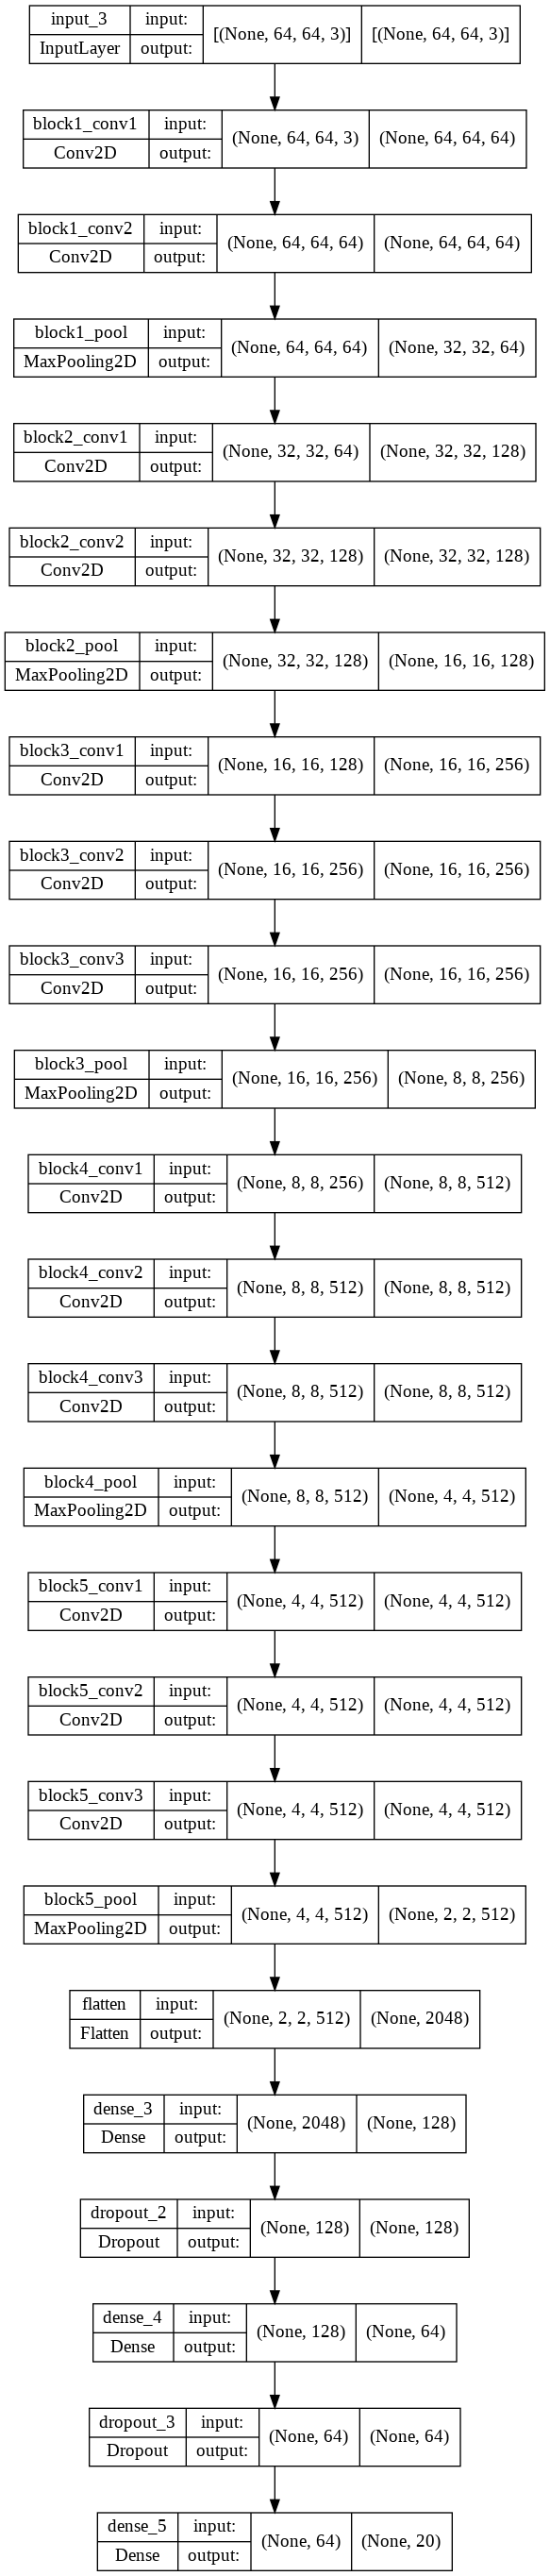

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(modelJ, show_shapes=True, show_layer_names=True)

In [ ]:
modelJ.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)


#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 117s 2s/step - loss: 2.5526 - accuracy: 0.2552 - val_loss: 1.7017 - val_accuracy: 0.6107
Epoch 2/15
62/62 [==============================] - 112s 2s/step - loss: 1.6106 - accuracy: 0.5300 - val_loss: 0.9680 - val_accuracy: 0.7911
Epoch 3/15
62/62 [==============================] - 108s 2s/step - loss: 1.0779 - accuracy: 0.6909 - val_loss: 0.6582 - val_accuracy: 0.8464
Epoch 4/15
62/62 [==============================] - 111s 2s/step - loss: 0.8150 - accuracy: 0.7711 - val_loss: 0.4800 - val_accuracy: 0.8821
Epoch 5/15
62/62 [==============================] - 107s 2s/step - loss: 0.6648 - accuracy: 0.8290 - val_loss: 0.3821 - val_accuracy: 0.9000
Epoch 6/15
62/62 [==============================] - 110s 2s/step - loss: 0.5675 - accuracy: 0.8608 - val_loss: 0.3808 - val_accuracy: 0.8875
Epoch 7/15
62/62 [==============================] - 111s 2s/step - loss: 0.4959 - accuracy: 0.8659 - val_loss: 0.2995 - val_accuracy: 0.9071
Epoch 8/15
62

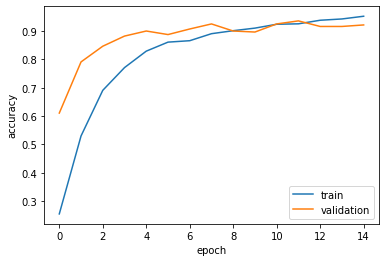

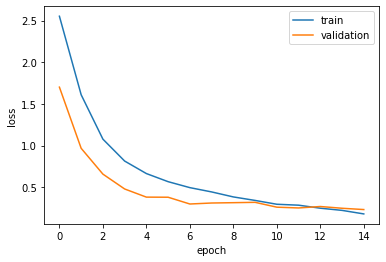

In [ ]:
# fit the model
H = modelJ.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result J/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result J/loss.png', bbox_inches="tight")
plt.show()

modelJ.save("/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model J.h5")

In [ ]:
modelJ.evaluate(train_x,train_y,batch_size=32) 

62/62 [==============================] - 125s 2s/step - loss: 0.0631 - accuracy: 0.9859


[0.06308934837579727, 0.9858799576759338]

In [ ]:
modelJ.evaluate(val_x,val_y,batch_size=32) 

18/18 [==============================] - 24s 1s/step - loss: 0.2329 - accuracy: 0.9214


[0.2329196184873581, 0.9214285612106323]

In [ ]:
modelJ.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 24s 2s/step - loss: 0.7745 - accuracy: 0.8576


[0.7745054364204407, 0.8576158881187439]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model J.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        18
           1       0.87      1.00      0.93        13
           2       1.00      0.94      0.97        16
           3       0.93      0.74      0.82        19
           4       1.00      0.88      0.94        17
           5       0.93      1.00      0.97        14
           6       0.67      0.91      0.77        11
           7       0.87      0.81      0.84        16
           8       0.93      0.93      0.93        15
           9       0.81      0.93      0.87        14
          10       0.80      0.75      0.77        16
          11       0.81      0.76      0.79        17
          12       0.67      0.83      0.74        12
          13       0.81      0.76      0.79        17
          14       0.80      0.80      0.80        15
          15       0.87      0.81      0.84        16
          16       0.87      0.87      0.87        15
          17       0.73    

# **Model K**

Flatten + Dense(128) + Dropout (0.2) + Dense(64) + Dropout (0.2) + Dense(20) + Rmsprop

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = Dense(128,activation = "relu")(X)
X = Dropout(0.2)(X)
X = Dense(64, activation = "relu")(X)
X = Dropout(0.2)(X)
X = Dense(20,activation = "softmax")(X)

modelK= Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelK.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelK.layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

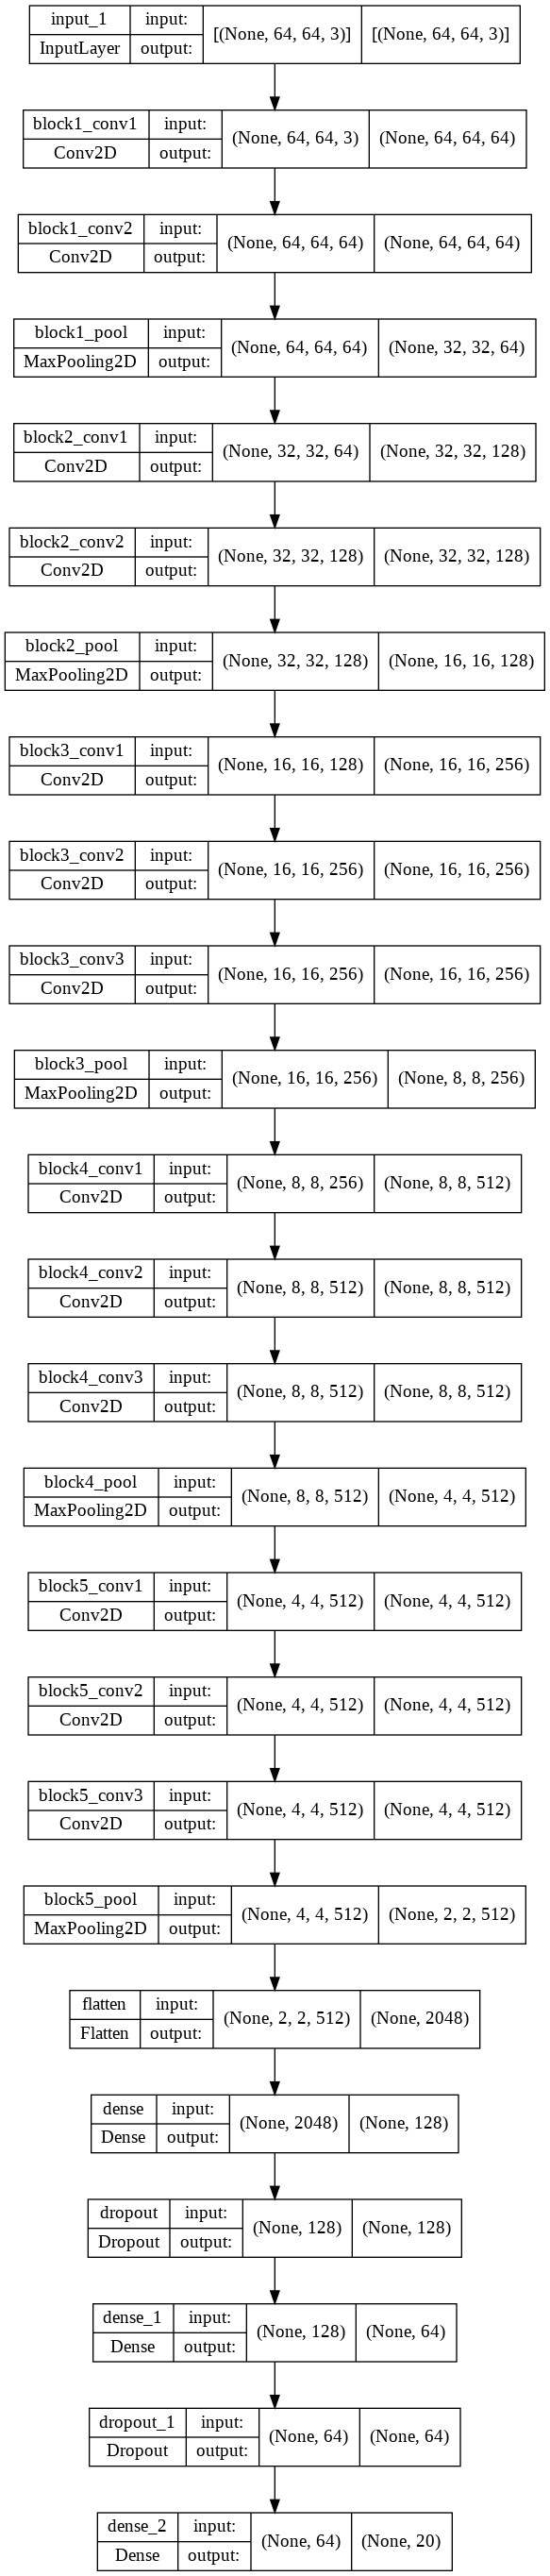

In [ ]:
plot_model(modelK, show_shapes=True, show_layer_names=True)

In [ ]:
modelK.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="rmsprop",
  metrics=['accuracy']
)


#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 80s 1s/step - loss: 2.5274 - accuracy: 0.2456 - val_loss: 1.7320 - val_accuracy: 0.5804
Epoch 2/15
62/62 [==============================] - 78s 1s/step - loss: 1.6449 - accuracy: 0.5356 - val_loss: 1.0054 - val_accuracy: 0.7875
Epoch 3/15
62/62 [==============================] - 78s 1s/step - loss: 1.1581 - accuracy: 0.6707 - val_loss: 0.6687 - val_accuracy: 0.8518
Epoch 4/15
62/62 [==============================] - 79s 1s/step - loss: 0.9030 - accuracy: 0.7484 - val_loss: 0.5537 - val_accuracy: 0.8446
Epoch 5/15
62/62 [==============================] - 78s 1s/step - loss: 0.7646 - accuracy: 0.7832 - val_loss: 0.4754 - val_accuracy: 0.8804
Epoch 6/15
62/62 [==============================] - 78s 1s/step - loss: 0.6263 - accuracy: 0.8381 - val_loss: 0.3960 - val_accuracy: 0.8929
Epoch 7/15
62/62 [==============================] - 79s 1s/step - loss: 0.5553 - accuracy: 0.8593 - val_loss: 0.3617 - val_accuracy: 0.8964
Epoch 8/15
62/62 [==

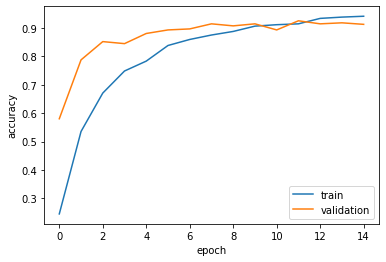

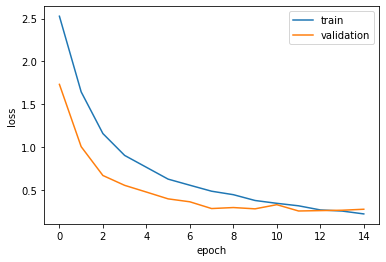

In [ ]:
# fit the model
H = modelK.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result K/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result K/loss.png', bbox_inches="tight")
plt.show()

modelK.save("/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model K.h5")

In [ ]:
modelK.evaluate(train_x,train_y,batch_size=32) 

62/62 [==============================] - 129s 2s/step - loss: 0.0901 - accuracy: 0.9768


[0.09009493142366409, 0.9768028259277344]

In [ ]:
modelJ.evaluate(val_x,val_y,batch_size=32) 

18/18 [==============================] - 35s 2s/step - loss: 0.2329 - accuracy: 0.9214


[0.2329196184873581, 0.9214285612106323]

In [ ]:
modelK.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 10s 917ms/step - loss: 0.7586 - accuracy: 0.8510


[0.758628785610199, 0.8509933948516846]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model K.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.80      0.92      0.86        13
           2       1.00      0.94      0.97        16
           3       0.93      0.82      0.87        17
           4       1.00      1.00      1.00        15
           5       0.93      1.00      0.97        14
           6       0.73      0.85      0.79        13
           7       0.93      0.74      0.82        19
           8       0.93      0.88      0.90        16
           9       0.81      0.81      0.81        16
          10       0.80      0.60      0.69        20
          11       0.75      0.71      0.73        17
          12       0.67      0.91      0.77        11
          13       0.75      0.80      0.77        15
          14       0.80      0.80      0.80        15
          15       0.80      0.80      0.80        15
          16       0.80      0.92      0.86        13
          17       0.80    

# **Model L**

Flatten + BatchNormalization + Dense(128) + BatchNormalization + Dense(64) + BatchNormalization + Dense(20) + Adam

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(128,activation = "relu")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(64, activation = "relu")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(20,activation = "softmax")(X)

modelL = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelL.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelL.layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

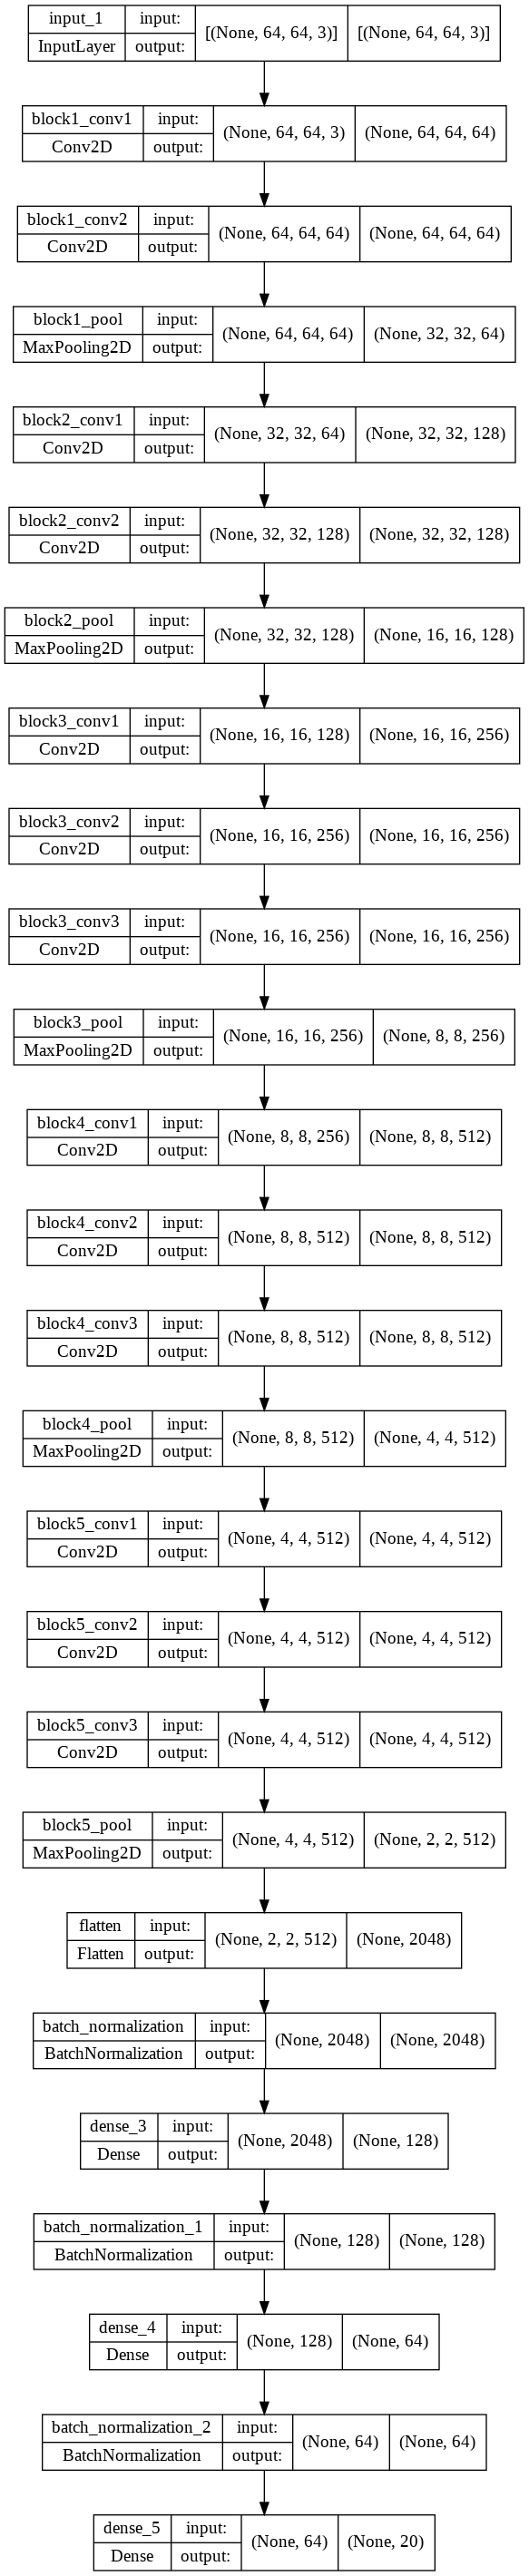

In [ ]:
plot_model(modelL, show_shapes=True, show_layer_names=True)

In [ ]:
modelL.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 79s 1s/step - loss: 1.5602 - accuracy: 0.5734 - val_loss: 2.0163 - val_accuracy: 0.5036
Epoch 2/15
62/62 [==============================] - 78s 1s/step - loss: 0.5285 - accuracy: 0.8981 - val_loss: 1.2849 - val_accuracy: 0.7857
Epoch 3/15
62/62 [==============================] - 77s 1s/step - loss: 0.2750 - accuracy: 0.9602 - val_loss: 0.8749 - val_accuracy: 0.8536
Epoch 4/15
62/62 [==============================] - 77s 1s/step - loss: 0.1610 - accuracy: 0.9773 - val_loss: 0.6330 - val_accuracy: 0.8732
Epoch 5/15
62/62 [==============================] - 79s 1s/step - loss: 0.0943 - accuracy: 0.9924 - val_loss: 0.4639 - val_accuracy: 0.8839
Epoch 6/15
62/62 [==============================] - 77s 1s/step - loss: 0.0585 - accuracy: 0.9985 - val_loss: 0.3897 - val_accuracy: 0.8929
Epoch 7/15
62/62 [==============================] - 78s 1s/step - loss: 0.0380 - accuracy: 0.9985 - val_loss: 0.3202 - val_accuracy: 0.9107
Epoch 8/15
62/62 [==

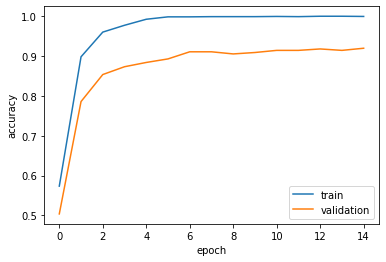

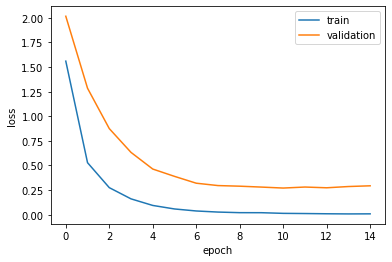

In [ ]:
# fit the model
H = modelL.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result L/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result L/loss.png', bbox_inches="tight")
plt.show()

modelL.save("/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model L.h5")

In [ ]:
modelL.evaluate(train_x,train_y,batch_size=32) 

62/62 [==============================] - 92s 1s/step - loss: 0.0019 - accuracy: 1.0000


[0.0018752759788185358, 1.0]

In [ ]:
modelL.evaluate(val_x,val_y,batch_size=32) 

18/18 [==============================] - 23s 1s/step - loss: 0.2937 - accuracy: 0.9196


[0.2937193512916565, 0.9196428656578064]

In [ ]:
modelL.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 9s 926ms/step - loss: 0.8396 - accuracy: 0.8510


[0.8396276235580444, 0.8509933948516846]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model L.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.73      0.92      0.81        12
           2       1.00      0.94      0.97        16
           3       1.00      0.88      0.94        17
           4       1.00      0.94      0.97        16
           5       0.93      1.00      0.97        14
           6       0.67      0.91      0.77        11
           7       0.87      0.76      0.81        17
           8       0.87      0.93      0.90        14
           9       0.81      0.87      0.84        15
          10       0.80      0.67      0.73        18
          11       0.81      0.65      0.72        20
          12       0.60      0.90      0.72        10
          13       0.75      0.80      0.77        15
          14       0.87      0.72      0.79        18
          15       0.87      0.81      0.84        16
          16       0.87      0.81      0.84        16
          17       0.87    

# **Model M**

Flatten + BatchNormalization + Dense(128) + BatchNormalization + Dense(64) + BatchNormalization + Dense(20) + Rmsprop

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(128,activation = "relu")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(64, activation = "relu")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(20,activation = "softmax")(X)

modelM = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelM.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelM.layers):
    print(i, layer.name, layer.trainable)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

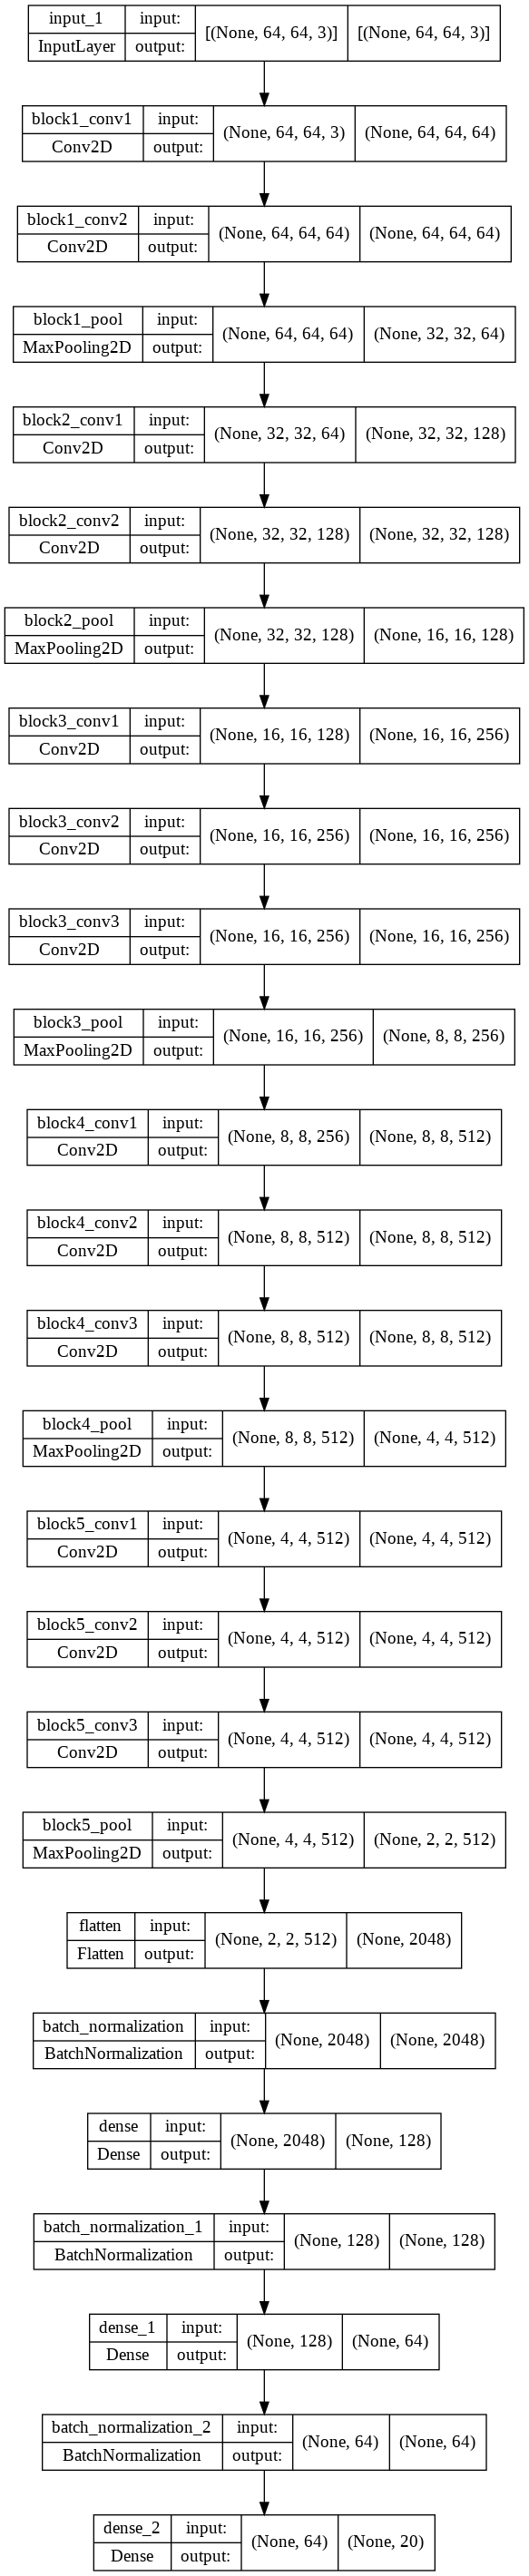

In [ ]:
plot_model(modelM, show_shapes=True, show_layer_names=True)

In [ ]:
modelM.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="rmsprop",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 78s 1s/step - loss: 1.3683 - accuracy: 0.6238 - val_loss: 1.9626 - val_accuracy: 0.5625
Epoch 2/15
62/62 [==============================] - 77s 1s/step - loss: 0.4538 - accuracy: 0.9143 - val_loss: 1.2208 - val_accuracy: 0.8018
Epoch 3/15
62/62 [==============================] - 79s 1s/step - loss: 0.2418 - accuracy: 0.9566 - val_loss: 0.8125 - val_accuracy: 0.8464
Epoch 4/15
62/62 [==============================] - 78s 1s/step - loss: 0.1300 - accuracy: 0.9773 - val_loss: 0.5595 - val_accuracy: 0.8679
Epoch 5/15
62/62 [==============================] - 77s 1s/step - loss: 0.0748 - accuracy: 0.9884 - val_loss: 0.4569 - val_accuracy: 0.8732
Epoch 6/15
62/62 [==============================] - 79s 1s/step - loss: 0.0405 - accuracy: 0.9934 - val_loss: 0.3443 - val_accuracy: 0.8982
Epoch 7/15
62/62 [==============================] - 77s 1s/step - loss: 0.0291 - accuracy: 0.9965 - val_loss: 0.2841 - val_accuracy: 0.9071
Epoch 8/15
62/62 [==

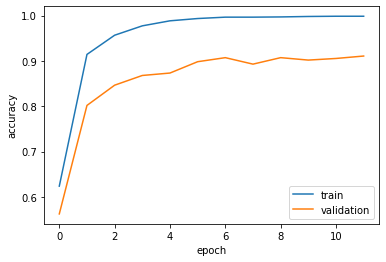

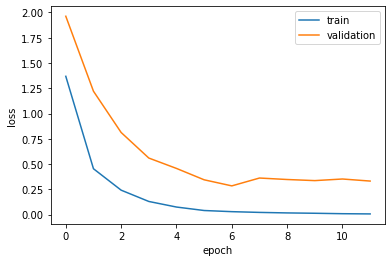

In [ ]:
# fit the model
H = modelM.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result M/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result M/loss.png', bbox_inches="tight")
plt.show()

modelM.save("/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model M.h5")

In [ ]:
modelM.evaluate(train_x,train_y,batch_size=32) 

62/62 [==============================] - 82s 1s/step - loss: 0.0013 - accuracy: 1.0000


[0.0012510365340858698, 1.0]

In [ ]:
modelM.evaluate(val_x,val_y,batch_size=32) 

18/18 [==============================] - 25s 1s/step - loss: 0.3318 - accuracy: 0.9107


[0.3317739963531494, 0.9107142686843872]

In [ ]:
modelM.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 9s 931ms/step - loss: 1.1654 - accuracy: 0.8278


[1.1654400825500488, 0.8278145790100098]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model M.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94        17
           1       0.87      0.93      0.90        14
           2       1.00      0.88      0.94        17
           3       0.93      0.74      0.82        19
           4       0.87      0.93      0.90        14
           5       0.93      1.00      0.97        14
           6       0.67      0.83      0.74        12
           7       0.87      0.81      0.84        16
           8       0.93      0.88      0.90        16
           9       0.69      0.73      0.71        15
          10       0.80      0.67      0.73        18
          11       0.81      0.65      0.72        20
          12       0.53      0.80      0.64        10
          13       0.75      0.71      0.73        17
          14       0.80      0.80      0.80        15
          15       0.80      0.80      0.80        15
          16       0.80      0.92      0.86        13
          17       0.80    

# **Model N**

Flatten + BatchNormalization + Dense(128) + Dropout (0.2) + BatchNormalization + Dense(64) + Dropout (0.2) + BatchNormalization + Dense(20) + Adam

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(128,activation = "relu")(X)
X = Dropout(0.2)(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(64, activation = "relu")(X)
X = Dropout(0.2)(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(20,activation = "softmax")(X)

modelN = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelN.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelN.layers):
    print(i, layer.name, layer.trainable)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

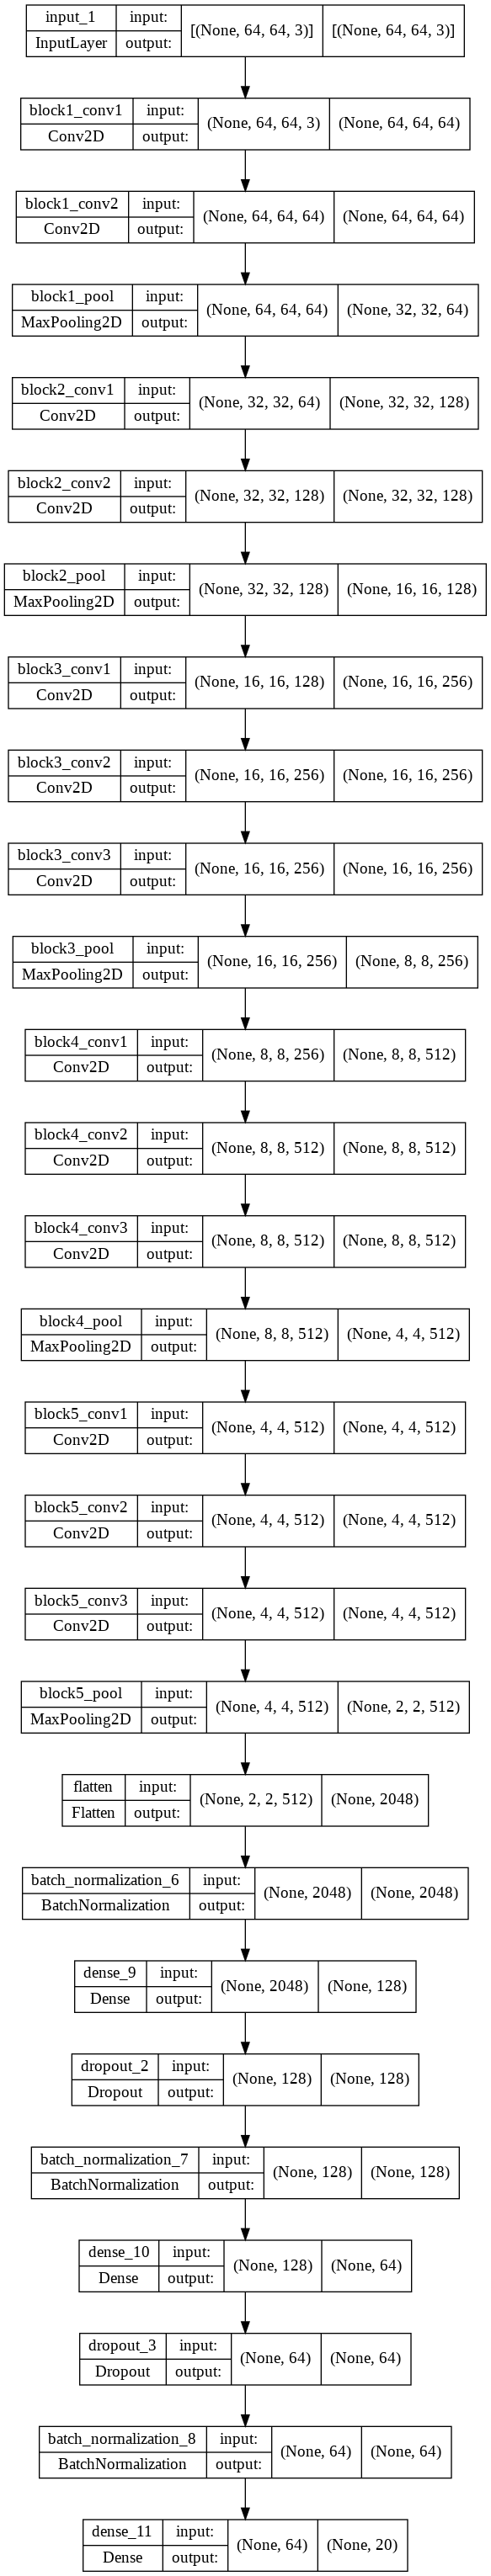

In [ ]:
plot_model(modelN, show_shapes=True, show_layer_names=True)

In [ ]:
modelN.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 79s 1s/step - loss: 2.0675 - accuracy: 0.4049 - val_loss: 2.0092 - val_accuracy: 0.6232
Epoch 2/15
62/62 [==============================] - 79s 1s/step - loss: 1.0140 - accuracy: 0.7499 - val_loss: 1.3953 - val_accuracy: 0.8161
Epoch 3/15
62/62 [==============================] - 79s 1s/step - loss: 0.7036 - accuracy: 0.8447 - val_loss: 0.9460 - val_accuracy: 0.8571
Epoch 4/15
62/62 [==============================] - 78s 1s/step - loss: 0.5195 - accuracy: 0.8921 - val_loss: 0.6448 - val_accuracy: 0.8839
Epoch 5/15
62/62 [==============================] - 79s 1s/step - loss: 0.3975 - accuracy: 0.9148 - val_loss: 0.4830 - val_accuracy: 0.8964
Epoch 6/15
62/62 [==============================] - 77s 1s/step - loss: 0.2763 - accuracy: 0.9395 - val_loss: 0.3893 - val_accuracy: 0.9018
Epoch 7/15
62/62 [==============================] - 78s 1s/step - loss: 0.2390 - accuracy: 0.9531 - val_loss: 0.3692 - val_accuracy: 0.8964
Epoch 8/15
62/62 [==

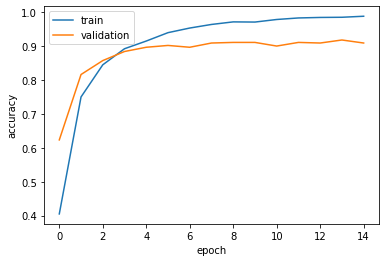

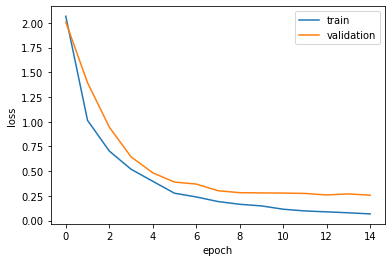

In [ ]:
# fit the model
H = modelN.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result N/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result N/loss.png', bbox_inches="tight")
plt.show()

modelN.save("/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model N.h5")

In [ ]:
modelN.evaluate(train_x,train_y,batch_size=32) 

62/62 [==============================] - 92s 1s/step - loss: 0.0037 - accuracy: 1.0000


[0.003652599873021245, 1.0]

In [ ]:
modelN.evaluate(val_x,val_y,batch_size=32) 

18/18 [==============================] - 26s 1s/step - loss: 0.2565 - accuracy: 0.9089


[0.2564985156059265, 0.9089285731315613]

In [ ]:
modelN.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 9s 918ms/step - loss: 0.8771 - accuracy: 0.8510


[0.8770551085472107, 0.8509933948516846]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model N.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94        17
           1       0.87      0.87      0.87        15
           2       1.00      0.83      0.91        18
           3       0.93      0.78      0.85        18
           4       0.93      0.93      0.93        15
           5       0.93      0.93      0.93        15
           6       0.73      0.85      0.79        13
           7       0.87      0.81      0.84        16
           8       0.80      0.92      0.86        13
           9       0.81      0.93      0.87        14
          10       0.73      0.79      0.76        14
          11       0.88      0.67      0.76        21
          12       0.60      1.00      0.75         9
          13       0.75      0.80      0.77        15
          14       0.73      0.73      0.73        15
          15       0.93      0.82      0.87        17
          16       0.87      0.93      0.90        14
          17       0.87    

# **Model O**

Flatten + BatchNormalization + Dense(128) + Dropout (0.2) + BatchNormalization + Dense(64) + Dropout (0.2) + BatchNormalization + Dense(20) + Rmsprop

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(128,activation = "relu")(X)
X = Dropout(0.2)(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(64, activation = "relu")(X)
X = Dropout(0.2)(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(20,activation = "softmax")(X)

modelO = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelO.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelO.layers):
    print(i, layer.name, layer.trainable)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

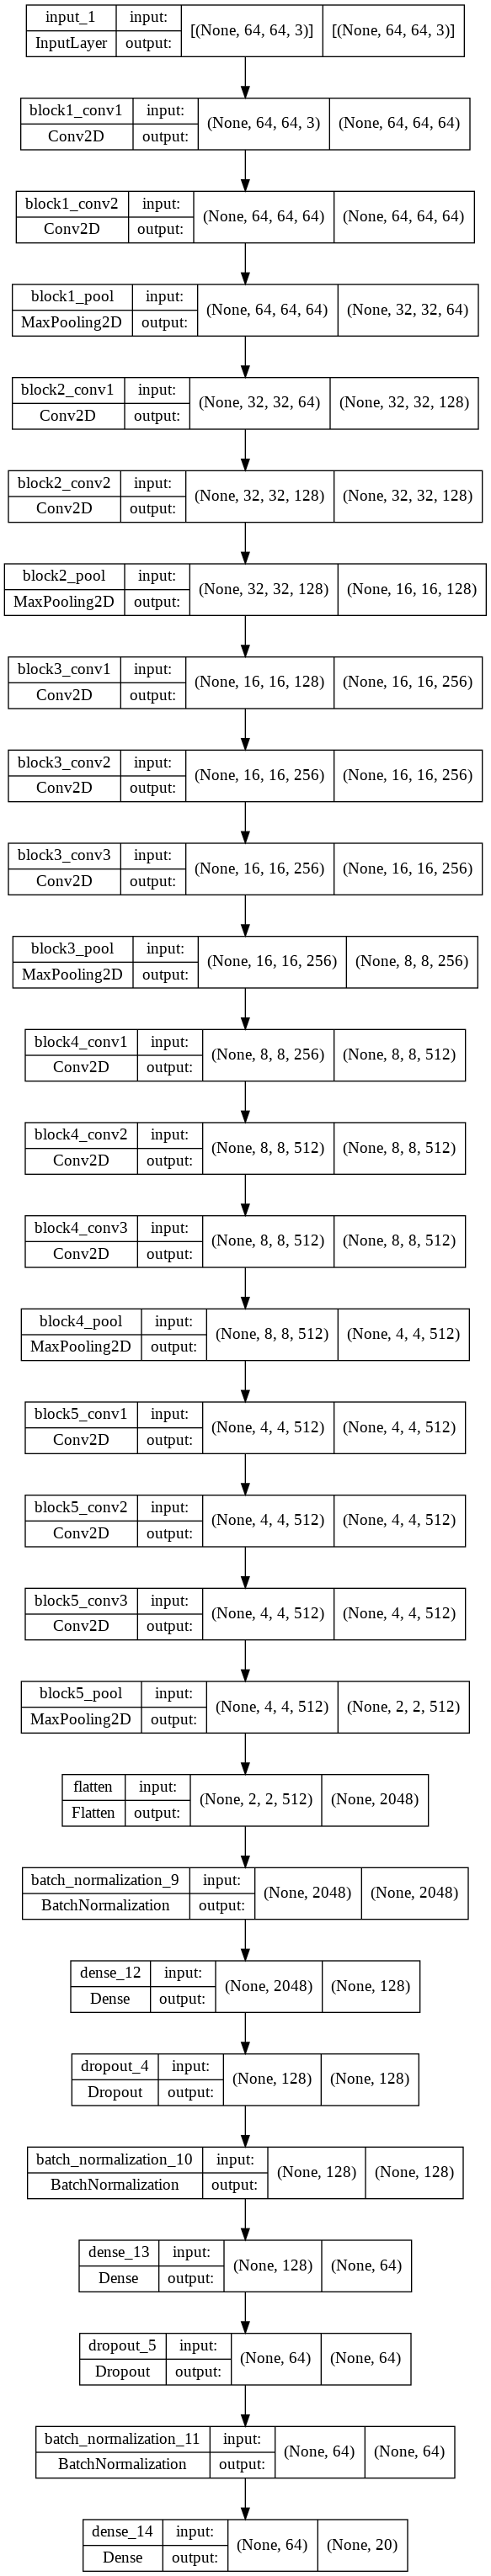

In [ ]:
plot_model(modelO, show_shapes=True, show_layer_names=True)

In [ ]:
modelO.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="rmsprop",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 80s 1s/step - loss: 1.8848 - accuracy: 0.4725 - val_loss: 2.0550 - val_accuracy: 0.5625
Epoch 2/15
62/62 [==============================] - 78s 1s/step - loss: 0.9063 - accuracy: 0.7968 - val_loss: 1.4008 - val_accuracy: 0.7982
Epoch 3/15
62/62 [==============================] - 81s 1s/step - loss: 0.6240 - accuracy: 0.8649 - val_loss: 0.8770 - val_accuracy: 0.8732
Epoch 4/15
62/62 [==============================] - 79s 1s/step - loss: 0.4524 - accuracy: 0.9022 - val_loss: 0.5869 - val_accuracy: 0.8893
Epoch 5/15
62/62 [==============================] - 80s 1s/step - loss: 0.3371 - accuracy: 0.9304 - val_loss: 0.4158 - val_accuracy: 0.9143
Epoch 6/15
62/62 [==============================] - 81s 1s/step - loss: 0.2603 - accuracy: 0.9486 - val_loss: 0.3488 - val_accuracy: 0.9107
Epoch 7/15
62/62 [==============================] - 80s 1s/step - loss: 0.2089 - accuracy: 0.9592 - val_loss: 0.3093 - val_accuracy: 0.9196
Epoch 8/15
62/62 [==

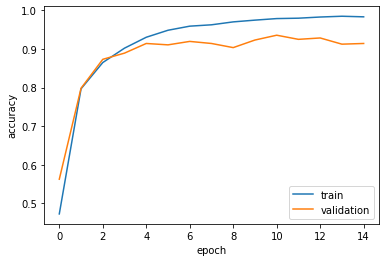

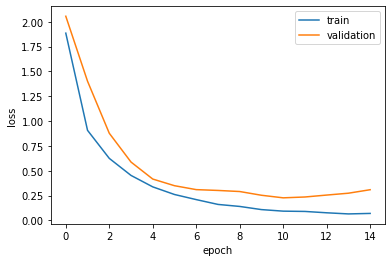

In [ ]:
# fit the model
H = modelO.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result O/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result O/loss.png', bbox_inches="tight")
plt.show()

modelO.save("/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model O.h5")

In [ ]:
modelO.evaluate(train_x,train_y,batch_size=32) 

62/62 [==============================] - 84s 1s/step - loss: 0.0022 - accuracy: 1.0000


[0.002230454469099641, 1.0]

In [ ]:
modelO.evaluate(val_x,val_y,batch_size=32) 

18/18 [==============================] - 23s 1s/step - loss: 0.3084 - accuracy: 0.9143


[0.3084490895271301, 0.9142857193946838]

In [ ]:
modelO.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 9s 941ms/step - loss: 0.9936 - accuracy: 0.8543


[0.9936116933822632, 0.8543046116828918]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model O.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       0.87      0.81      0.84        16
           2       1.00      0.88      0.94        17
           3       0.93      0.93      0.93        15
           4       0.93      0.93      0.93        15
           5       0.93      0.93      0.93        15
           6       0.73      0.85      0.79        13
           7       0.80      0.86      0.83        14
           8       0.87      0.81      0.84        16
           9       0.81      0.93      0.87        14
          10       0.80      0.80      0.80        15
          11       0.81      0.68      0.74        19
          12       0.60      0.90      0.72        10
          13       0.81      0.81      0.81        16
          14       0.87      0.76      0.81        17
          15       0.93      0.78      0.85        18
          16       0.87      0.81      0.84        16
          17       0.87    

# **Model P**

Flatten + Dense(128) + Dropout(0.2) + Dense(64) + Dropout(0.2) + Dense(20) + SGD

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = Dense(128,activation = "relu")(X)
X = Dropout(0.2)(X)
X = Dense(64, activation = "relu")(X)
X = Dropout(0.2)(X)
X = Dense(20,activation = "softmax")(X)

modelP = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelP.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelP.layers):
    print(i, layer.name, layer.trainable)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

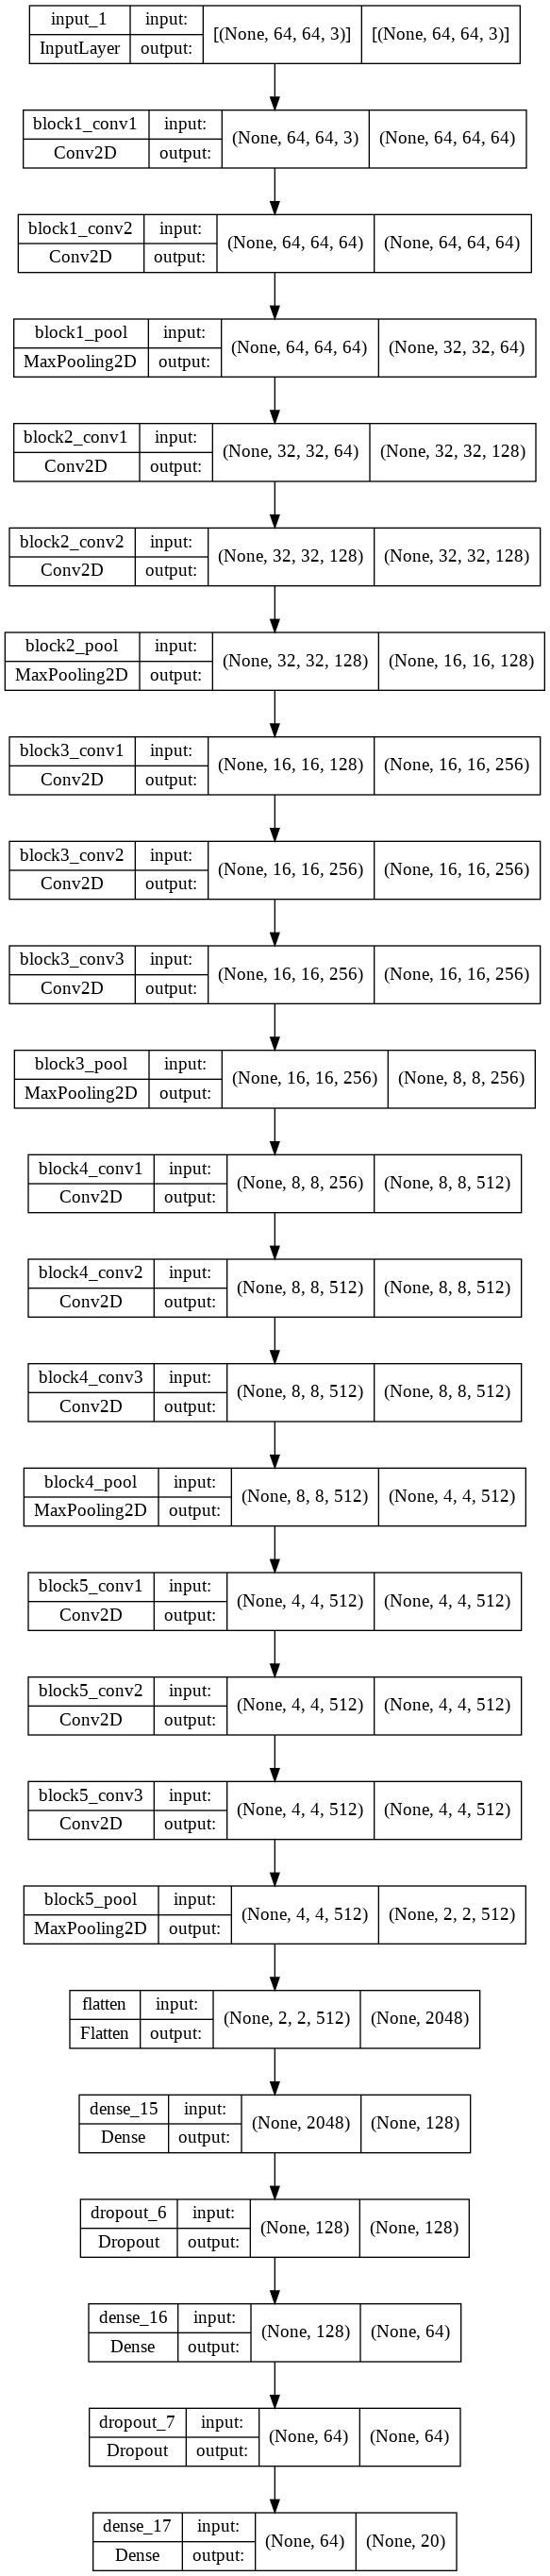

In [ ]:
plot_model(modelP, show_shapes=True, show_layer_names=True)

In [ ]:
modelP.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="SGD",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 81s 1s/step - loss: 2.9477 - accuracy: 0.1034 - val_loss: 2.7912 - val_accuracy: 0.1857
Epoch 2/15
62/62 [==============================] - 79s 1s/step - loss: 2.7572 - accuracy: 0.1775 - val_loss: 2.5630 - val_accuracy: 0.2946
Epoch 3/15
62/62 [==============================] - 88s 1s/step - loss: 2.5955 - accuracy: 0.2350 - val_loss: 2.3414 - val_accuracy: 0.4643
Epoch 4/15
62/62 [==============================] - 82s 1s/step - loss: 2.3893 - accuracy: 0.2869 - val_loss: 2.1185 - val_accuracy: 0.5250
Epoch 5/15
62/62 [==============================] - 79s 1s/step - loss: 2.2111 - accuracy: 0.3464 - val_loss: 1.9111 - val_accuracy: 0.5393
Epoch 6/15
62/62 [==============================] - 95s 2s/step - loss: 2.0586 - accuracy: 0.3873 - val_loss: 1.7216 - val_accuracy: 0.6054
Epoch 7/15
62/62 [==============================] - 80s 1s/step - loss: 1.9009 - accuracy: 0.4453 - val_loss: 1.5335 - val_accuracy: 0.6982
Epoch 8/15
62/62 [==

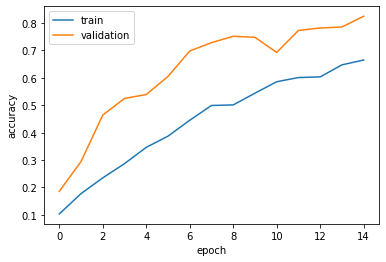

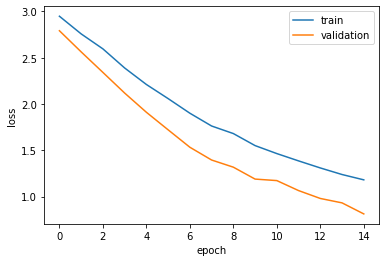

In [ ]:
# fit the model
H = modelP.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result P/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result P/loss.png', bbox_inches="tight")
plt.show()

modelP.save("/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model P.h5")

In [ ]:
modelP.evaluate(train_x,train_y,batch_size=32) 

62/62 [==============================] - 83s 1s/step - loss: 0.8558 - accuracy: 0.8411


[0.8557618856430054, 0.8411497473716736]

In [ ]:
modelP.evaluate(val_x,val_y,batch_size=32) 

18/18 [==============================] - 23s 1s/step - loss: 0.8136 - accuracy: 0.8250


[0.8136494159698486, 0.824999988079071]

In [ ]:
modelP.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 9s 923ms/step - loss: 1.0608 - accuracy: 0.7848


[1.0608234405517578, 0.7847682237625122]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model P.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       0.87      0.57      0.68        23
           2       1.00      0.88      0.94        17
           3       0.93      0.93      0.93        15
           4       0.67      0.91      0.77        11
           5       0.87      1.00      0.93        13
           6       0.60      0.64      0.62        14
           7       0.87      0.72      0.79        18
           8       0.67      0.91      0.77        11
           9       0.75      0.86      0.80        14
          10       0.60      0.82      0.69        11
          11       0.75      0.63      0.69        19
          12       0.60      0.90      0.72        10
          13       0.81      0.65      0.72        20
          14       0.73      0.79      0.76        14
          15       0.80      0.71      0.75        17
          16       0.80      0.92      0.86        13
          17       0.73    

# **Model Q**

Flatten + BatchNormalization + Dense(128) + BatchNormalization + Dense(64) + BatchNormalization + Dense(20) + SGD

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(128,activation = "relu")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(64, activation = "relu")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(20,activation = "softmax")(X)

modelQ = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelQ.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelQ.layers):
    print(i, layer.name, layer.trainable)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

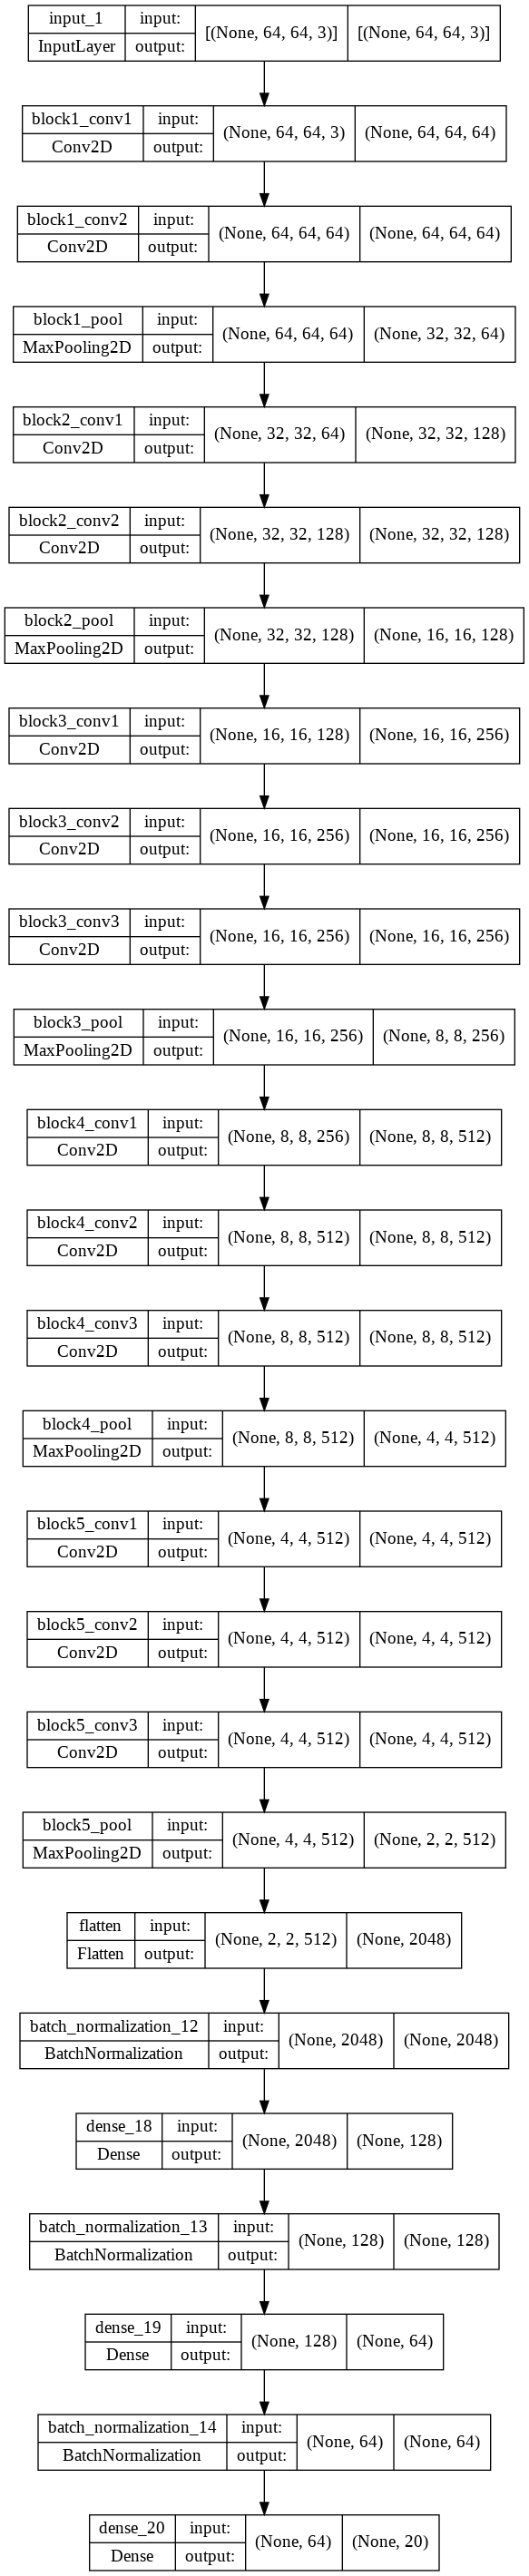

In [ ]:
plot_model(modelQ, show_shapes=True, show_layer_names=True)

In [ ]:
modelQ.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="SGD",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 82s 1s/step - loss: 2.2804 - accuracy: 0.3565 - val_loss: 2.6214 - val_accuracy: 0.3232
Epoch 2/15
62/62 [==============================] - 83s 1s/step - loss: 1.2210 - accuracy: 0.6894 - val_loss: 2.1552 - val_accuracy: 0.5250
Epoch 3/15
62/62 [==============================] - 79s 1s/step - loss: 0.8506 - accuracy: 0.8159 - val_loss: 1.6506 - val_accuracy: 0.7054
Epoch 4/15
62/62 [==============================] - 78s 1s/step - loss: 0.6557 - accuracy: 0.8810 - val_loss: 1.2229 - val_accuracy: 0.7821
Epoch 5/15
62/62 [==============================] - 80s 1s/step - loss: 0.5246 - accuracy: 0.9042 - val_loss: 0.9193 - val_accuracy: 0.8304
Epoch 6/15
62/62 [==============================] - 78s 1s/step - loss: 0.4389 - accuracy: 0.9274 - val_loss: 0.7386 - val_accuracy: 0.8518
Epoch 7/15
62/62 [==============================] - 79s 1s/step - loss: 0.3774 - accuracy: 0.9385 - val_loss: 0.6257 - val_accuracy: 0.8571
Epoch 8/15
62/62 [==

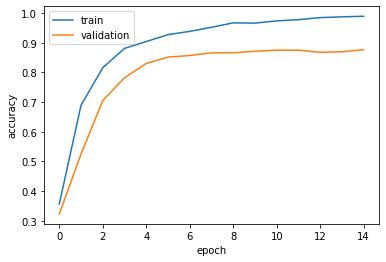

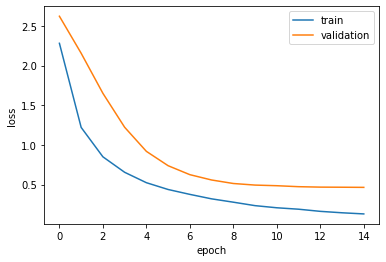

In [ ]:
# fit the model
H = modelQ.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result Q/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result Q/loss.png', bbox_inches="tight")
plt.show()

modelQ.save("/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model Q.h5")

In [ ]:
modelQ.evaluate(train_x,train_y,batch_size=32) 

62/62 [==============================] - 83s 1s/step - loss: 0.0673 - accuracy: 0.9980


[0.0672878846526146, 0.9979828596115112]

In [ ]:
modelQ.evaluate(val_x,val_y,batch_size=32) 

18/18 [==============================] - 23s 1s/step - loss: 0.4657 - accuracy: 0.8768


[0.4657343626022339, 0.8767856955528259]

In [ ]:
modelQ.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 9s 924ms/step - loss: 0.8587 - accuracy: 0.7980


[0.8587244153022766, 0.7980132699012756]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model Q.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87        17
           1       0.67      0.83      0.74        12
           2       1.00      0.94      0.97        16
           3       0.93      0.82      0.87        17
           4       0.93      1.00      0.97        14
           5       0.93      1.00      0.97        14
           6       0.67      0.91      0.77        11
           7       0.80      0.80      0.80        15
           8       0.87      0.76      0.81        17
           9       0.56      0.75      0.64        12
          10       0.87      0.72      0.79        18
          11       0.69      0.61      0.65        18
          12       0.60      0.64      0.62        14
          13       0.69      0.79      0.73        14
          14       0.80      0.60      0.69        20
          15       0.73      0.69      0.71        16
          16       0.80      0.75      0.77        16
          17       0.80    

# **Model R**

Flatten + BatchNormalization + Dense(128) + Dropout (0.2) + BatchNormalization + Dense(64) + Dropout (0.2) + BatchNormalization + Dense(20) + SGD

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(128,activation = "relu")(X)
X = Dropout(0.2)(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(64, activation = "relu")(X)
X = Dropout(0.2)(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(20,activation = "softmax")(X)

modelR = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelR.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelR.layers):
    print(i, layer.name, layer.trainable)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

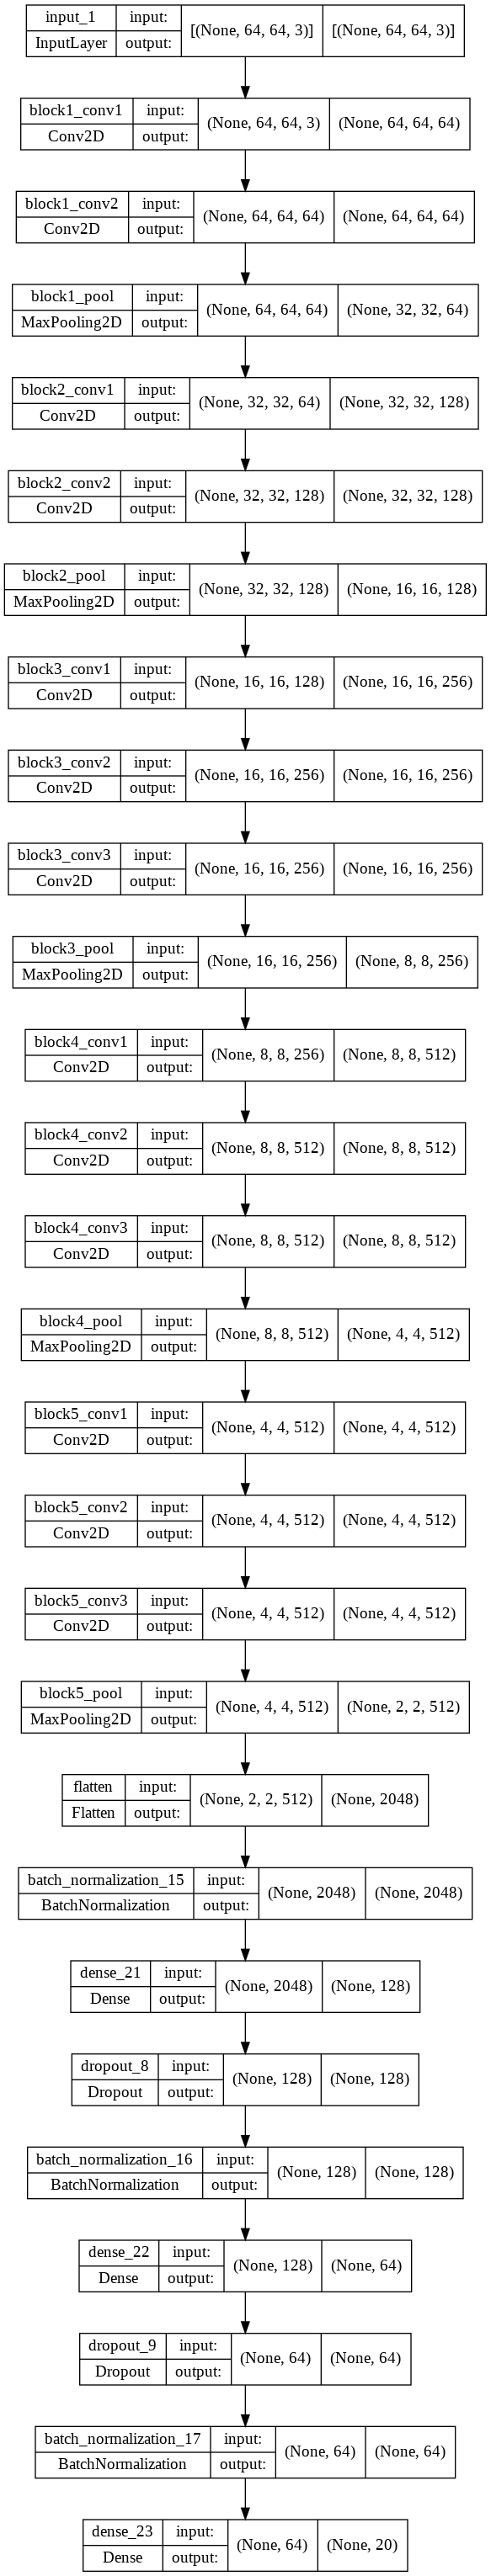

In [ ]:
plot_model(modelR, show_shapes=True, show_layer_names=True)

In [ ]:
modelR.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="SGD",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 81s 1s/step - loss: 2.7766 - accuracy: 0.2093 - val_loss: 2.7192 - val_accuracy: 0.2446
Epoch 2/15
62/62 [==============================] - 78s 1s/step - loss: 1.8409 - accuracy: 0.4634 - val_loss: 2.1807 - val_accuracy: 0.5179
Epoch 3/15
62/62 [==============================] - 79s 1s/step - loss: 1.4479 - accuracy: 0.6051 - val_loss: 1.7193 - val_accuracy: 0.6857
Epoch 4/15
62/62 [==============================] - 82s 1s/step - loss: 1.1686 - accuracy: 0.7105 - val_loss: 1.3627 - val_accuracy: 0.7625
Epoch 5/15
62/62 [==============================] - 79s 1s/step - loss: 1.0463 - accuracy: 0.7383 - val_loss: 1.0680 - val_accuracy: 0.8214
Epoch 6/15
62/62 [==============================] - 79s 1s/step - loss: 0.9445 - accuracy: 0.7811 - val_loss: 0.8571 - val_accuracy: 0.8554
Epoch 7/15
62/62 [==============================] - 78s 1s/step - loss: 0.8369 - accuracy: 0.8053 - val_loss: 0.7134 - val_accuracy: 0.8661
Epoch 8/15
62/62 [==

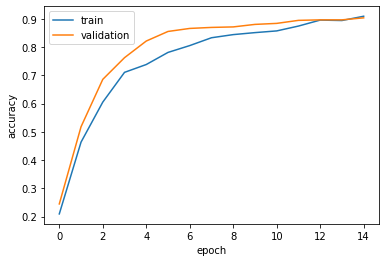

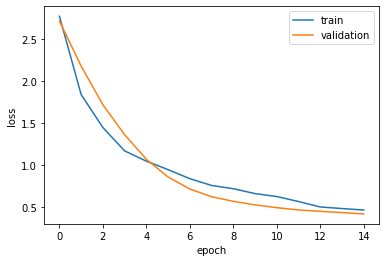

In [ ]:
# fit the model
H = modelR.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result R/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_64px/Result/Result R/loss.png', bbox_inches="tight")
plt.show()

modelR.save("/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model R.h5")

In [ ]:
modelR.evaluate(train_x,train_y,batch_size=32) 

62/62 [==============================] - 83s 1s/step - loss: 0.1833 - accuracy: 0.9743


[0.18325737118721008, 0.974281370639801]

In [ ]:
modelR.evaluate(val_x,val_y,batch_size=32) 

18/18 [==============================] - 25s 1s/step - loss: 0.4161 - accuracy: 0.9036


[0.4161103069782257, 0.9035714268684387]

In [ ]:
modelR.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 10s 975ms/step - loss: 0.7250 - accuracy: 0.8477


[0.7250239253044128, 0.8476821184158325]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_64px/Model/Model R.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.80      0.86      0.83        14
           2       1.00      0.94      0.97        16
           3       0.87      0.68      0.76        19
           4       1.00      0.94      0.97        16
           5       1.00      1.00      1.00        15
           6       0.60      0.90      0.72        10
           7       0.87      0.81      0.84        16
           8       0.87      0.93      0.90        14
           9       0.81      0.87      0.84        15
          10       0.73      0.73      0.73        15
          11       0.81      0.76      0.79        17
          12       0.73      0.79      0.76        14
          13       0.81      0.87      0.84        15
          14       0.73      0.69      0.71        16
          15       0.93      0.88      0.90        16
          16       0.80      0.86      0.83        14
          17       0.80    